<a href="https://colab.research.google.com/github/nikhilsawane/ROBO-7000-Transformers-for-Robotics/blob/main/assignments/minimal_transformer_date_reformatter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Minimal Transformer Encoder–Decoder (from scratch) — Date Reformatter  

A tiny, fully self-contained PyTorch notebook that implements a basic Transformer **decoder**
per class notes, extends it with an **encoder**, and trains on a synthetic **date reformatting** task.

**Task:** Convert `YYYY-MM-DD` → `Month DD, YYYY` (and back).  
This yields clean one-to-one-ish alignments that make attention easy to inspect.

---

### 👤 Author  
**Nikhil Sawane**  
ROBO 7000 — *Transformers for Robotics*, University of Colorado Boulder  
Instructor: Prof. Nikolaus Correll  

📅 *October 2025*  
🔗 [Medium Article: “A Minimal Transformer Encoder–Decoder: Teaching Attention with Date Reformatting”](https://medium.com/@nikhil.sawane/a-minimal-transformer-encoder-decoder-teaching-attention-with-date-reformatting-4e800b202325)

---

*Colab tip:* Runtime → **Change runtime type → GPU** (Optional; this trains fast on CPU too).




## Why this task?
- **Simple**: fixed character vocabulary; exact supervision.
- **Shows alignment**: cross-attention learns to copy from source in the right order.
- **Self-contained**: no downloads; reproducible.

## What you'll see
1. A **from-scratch decoder**: scaled dot-product attention + multi-head attention + position-wise feedforward.
2. A **tiny encoder** (same building blocks).
3. **Causal masks** and **padding masks**.
4. Training loop with teacher forcing, plus greedy decoding at test time.
5. **Attention heatmaps** for one example.


In [17]:

# Install & imports
# (Everything is stdlib / PyTorch / matplotlib; no internet needed in Colab.)

import math, random, time
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [18]:

# ==== 1) Synthetic seq2seq dataset: Date reformatting ====
# Source:  'YYYY-MM-DD'          e.g., '2013-04-09'
# Target:  'April 09, 2013'      e.g., 'April 09, 2013'

months = ['January','February','March','April','May','June','July','August','September','October','November','December']

def random_date():
    year = random.randint(1990, 2025)
    month = random.randint(1, 12)
    # naive day bound; good enough for training
    day = random.randint(1, 28)
    src = f"{year:04d}-{month:02d}-{day:02d}"
    tgt = f"{months[month-1]} {day:02d}, {year:04d}"
    return src, tgt

# Build vocab from all characters we might see
chars = list("0123456789- ,")+list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")
# ensure capitalized month names and lowercase are covered; keep it simple:
# months provide needed letters already

stoi = {ch:i+4 for i,ch in enumerate(sorted(set(chars)))}
# Reserve 0: <pad>, 1: <sos>, 2: <eos>, 3: <unk>
itos = {i:s for s,i in stoi.items()}
itos[0] = "<pad>"; itos[1] = "<sos>"; itos[2] = "<eos>"; itos[3] = "<unk>"

PAD, SOS, EOS, UNK = 0,1,2,3
vocab_size = len(itos)

def encode(s):
    return [stoi.get(ch, UNK) for ch in s]

def decode(ids):
    out = []
    for i in ids:
        if i==EOS: break
        if i in itos: out.append(itos[i])
    return "".join(out)

max_src_len = 10 # 'YYYY-MM-DD' -> 10 chars
max_tgt_len = 20 # 'Month DD, YYYY' <= ~20

def make_example():
    s,t = random_date()
    return encode(s), encode(t)

def pad_to_len(ids, L):
    ids = ids[:L-1] # leave room for EOS
    ids = [*ids, EOS]
    if len(ids) < L:
        ids = ids + [PAD]*(L-len(ids))
    return ids

def make_dataset(N=5000, seed=1337):
    random.seed(seed)
    srcs, tgts = [], []
    for _ in range(N):
        s,t = make_example()
        srcs.append(pad_to_len(s, max_src_len))
        tgts.append([SOS] + pad_to_len(t, max_tgt_len-1)) # add SOS on left
    X = torch.tensor(srcs, dtype=torch.long)
    Y = torch.tensor(tgts, dtype=torch.long)
    return X, Y

train_X, train_Y = make_dataset(6000, seed=123)
val_X,   val_Y   = make_dataset(600,  seed=456)

print('Vocab size:', vocab_size)
print('Train:', train_X.shape, train_Y.shape, ' Val:', val_X.shape, val_Y.shape)


Vocab size: 69
Train: torch.Size([6000, 10]) torch.Size([6000, 20])  Val: torch.Size([600, 10]) torch.Size([600, 20])


In [19]:

# ==== 2) Positional Encoding ====
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0)) # (1, L, d_model)
    def forward(self, x):
        # x: (B, L, d_model)
        L = x.size(1)
        return x + self.pe[:, :L, :]


In [20]:

# ==== 3) Attention & Multi-Head Attention (from scratch) ====
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = 1.0 / math.sqrt(d_k)
    def forward(self, Q, K, V, attn_mask=None):
        # Q,K,V: (B, h, L, d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale  # (B,h,L,L)
        if attn_mask is not None:
          scores = scores.masked_fill(attn_mask==0, -1e9)  # instead of -inf
        attn = F.softmax(scores, dim=-1)                             # (B,h,L,L)
        out = torch.matmul(attn, V)                                  # (B,h,L,d_k)
        return out, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.h = num_heads
        self.d_k = d_model // num_heads
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.attn = ScaledDotProductAttention(self.d_k)

    def split_heads(self, x):
        # x: (B,L,d_model) -> (B,h,L,d_k)
        B,L,D = x.shape
        x = x.view(B, L, self.h, self.d_k).transpose(1,2)
        return x

    def combine_heads(self, x):
        # x: (B,h,L,d_k) -> (B,L,D)
        B,h,L,d_k = x.shape
        x = x.transpose(1,2).contiguous().view(B, L, h*d_k)
        return x

    def forward(self, q, k, v, attn_mask=None):
        Q = self.split_heads(self.q_proj(q))
        K = self.split_heads(self.k_proj(k))
        V = self.split_heads(self.v_proj(v))
        out, attn = self.attn(Q, K, V, attn_mask)
        out = self.combine_heads(out)
        return self.out_proj(out), attn


In [21]:

# ==== 4) Transformer Blocks ====
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
    def forward(self, x): return self.net(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, src_key_padding_mask):
        # Self-attention
        attn_mask = self.make_padding_attn_mask(src_key_padding_mask)  # (B,1,L,L)
        attn_out, _ = self.self_attn(x, x, x, attn_mask)
        x = self.norm1(x + self.drop(attn_out))
        # FF
        x = self.norm2(x + self.drop(self.ff(x)))
        return x

    @staticmethod
    def make_padding_attn_mask(kpm):
        # kpm: (B,L) 1 means keep, 0 means pad
        B,L = kpm.shape
        mask = kpm.unsqueeze(1).unsqueeze(2) & kpm.unsqueeze(1).unsqueeze(1)  # (B,1,L,L)
        return mask

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_out, tgt_kpm, src_kpm):
        # Causal mask for decoder self-attn
        causal = self.make_causal_mask(x.size(1), x.device)  # (1,1,L,L)
        self_mask = causal & self.make_padding_attn_mask(tgt_kpm) # (B,1,L,L)
        sa_out, self_attn = self.self_attn(x, x, x, self_mask)
        x = self.norm1(x + self.drop(sa_out))

        # Cross-attn: query=decoder, key/value=encoder
        cross_mask = self.make_cross_mask(tgt_kpm, src_kpm) # (B,1,Lt,Ls)
        ca_out, cross_attn = self.cross_attn(x, enc_out, enc_out, cross_mask)
        x = self.norm2(x + self.drop(ca_out))

        x = self.norm3(x + self.drop(self.ff(x)))
        return x, self_attn, cross_attn

    @staticmethod
    def make_causal_mask(L, device):
        m = torch.tril(torch.ones(L, L, dtype=torch.bool, device=device))
        return m.unsqueeze(0).unsqueeze(0)

    @staticmethod
    def make_padding_attn_mask(kpm):
        B,L = kpm.shape
        return kpm.unsqueeze(1).unsqueeze(2) & kpm.unsqueeze(1).unsqueeze(1)

    @staticmethod
    def make_cross_mask(tgt_kpm, src_kpm):
        # (B,Lt,1) & (B,1,Ls)
        return tgt_kpm.unsqueeze(1).unsqueeze(3) & src_kpm.unsqueeze(1).unsqueeze(2)


In [22]:

# ==== 5) Full Encoder–Decoder ====
class Encoder(nn.Module):
    def __init__(self, vocab, d_model, n_layers, n_heads, d_ff, max_len):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model)
        self.pos = SinusoidalPositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
    def forward(self, src, src_kpm):
     #   x = self.emb(src) * math.sqrt(self.emb.embedding_dim)
        x = self.emb(src)
        x = self.pos(x)
        for layer in self.layers:
            x = layer(x, src_kpm)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab, d_model, n_layers, n_heads, d_ff, max_len):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model)
        self.pos = SinusoidalPositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, tgt, enc_out, tgt_kpm, src_kpm):
   #     x = self.emb(tgt) * math.sqrt(self.emb.embedding_dim)
        x = self.emb(tgt)
        x = self.pos(x)
        last_self, last_cross = None, None
        for layer in self.layers:
            x, self_attn, cross_attn = layer(x, enc_out, tgt_kpm, src_kpm)
            last_self, last_cross = self_attn, cross_attn  # keep last for viz
        return self.proj(x), last_self, last_cross

class TinyTransformer(nn.Module):
    def __init__(self, vocab, d_model=128, n_layers=2, n_heads=4, d_ff=256, max_len=256):
        super().__init__()
        self.enc = Encoder(vocab, d_model, n_layers, n_heads, d_ff, max_len)
        self.dec = Decoder(vocab, d_model, n_layers, n_heads, d_ff, max_len)

    @staticmethod
    def kpm_from_tokens(tokens, pad_idx=0):
        # key padding mask: 1 where real token, 0 where pad
        return (tokens != pad_idx).to(torch.bool)

    def forward(self, src, tgt):
        src_kpm = self.kpm_from_tokens(src)
        tgt_kpm = self.kpm_from_tokens(tgt)
        enc_out = self.enc(src, src_kpm)
        logits, self_attn, cross_attn = self.dec(tgt, enc_out, tgt_kpm, src_kpm)
        return logits, self_attn, cross_attn


In [23]:

# ==== 6) Training & Evaluation ====
torch.manual_seed(0)

model = TinyTransformer(vocab_size).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD)

def batch_iter(X, Y, bs=128):
    N = X.size(0)
    idx = torch.randperm(N)
    for i in range(0, N, bs):
        j = idx[i:i+bs]
        yield X[j].to(device), Y[j].to(device)

def train_epoch():
    model.train()
    total, n = 0.0, 0
    for src, tgt in batch_iter(train_X, train_Y, bs=256):
        logits, _, _ = model(src, tgt[:,:-1])
        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt[:,1:].reshape(-1))
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # <— gradient clipping
        opt.step()
        total += loss.item()
        n += 1
    return total/n


@torch.no_grad()
def greedy_decode(src, max_len=32):
    model.eval()
    src = src.to(device)
    B = src.size(0)
    tgt = torch.full((B,1), SOS, dtype=torch.long, device=device)
    for _ in range(max_len):
        logits, _, _ = model(src, tgt)
        next_token = logits[:,-1,:].argmax(dim=-1, keepdim=True) # (B,1)
        tgt = torch.cat([tgt, next_token], dim=1)
        if (next_token==EOS).all(): break
    return tgt

@torch.no_grad()
def eval_sample(k=5):
    model.eval()
    idx = torch.randint(0, val_X.size(0), (k,))
    src = val_X[idx]
    pred = greedy_decode(src, max_len=max_tgt_len)
    outs = []
    for i in range(k):
        s = decode(src[i].tolist())
        p = decode(pred[i].tolist()[1:]) # drop SOS
        outs.append((s,p))
    return outs

epochs = 12
for ep in range(1, epochs+1):
    t0=time.time()
    loss = train_epoch()
    ex = eval_sample(3)
    dt=time.time()-t0
    print(f"Epoch {ep:02d} | loss {loss:.3f} | {dt:.1f}s")
    for s,p in ex:
        print("  SRC:", s, "  PRED:", p)


Epoch 01 | loss 3.689 | 20.5s
  SRC: 1998-08-2   PRED: 2   2 2 2 2 2 2 2 2 
  SRC: 1999-09-0   PRED: 0   2 2 2 2 2 2 2 2 
  SRC: 1992-03-1   PRED: 0   2 2 2 2 2 2 2 2 
Epoch 02 | loss 2.919 | 15.0s
  SRC: 2014-11-2   PRED: Ap 20120120120199999
  SRC: 1994-08-0   PRED: Ap 20120199999999999
  SRC: 2017-12-0   PRED: Ap 202020120120
Epoch 03 | loss 2.268 | 14.6s
  SRC: 1992-12-2   PRED: Juar 201999999999999
  SRC: 1990-08-1   PRED: Apter 19999999999999
  SRC: 2000-01-2   PRED: Ap 20000000000000020
Epoch 04 | loss 1.767 | 14.6s
  SRC: 2004-04-0   PRED: Juaruar 200000000000
  SRC: 1998-06-2   PRED: Juar 201999999999999
  SRC: 2025-05-1   PRED: Juary 201, 201
Epoch 05 | loss 1.429 | 14.5s
  SRC: 1993-01-0   PRED: Juary 19999999999999
  SRC: 2014-06-2   PRED: Juary 201, 201
  SRC: 2004-09-2   PRED: Juaruary 2000000
Epoch 06 | loss 1.172 | 19.8s
  SRC: 1999-08-2   PRED: August 1999999999999
  SRC: 2014-06-2   PRED: June 201, 201
  SRC: 2022-11-1   PRED: Juary 201, 201
Epoch 07 | loss 0.964 | 15

Source: 2018-08-1
Pred:   August 18, 100101010


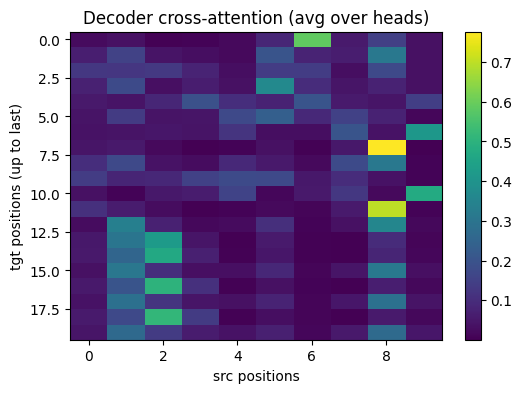

In [24]:

# ==== 7) Visualize attention on one example ====
@torch.no_grad()
def get_attn_maps(src):
    model.eval()
    # Run one step at a time to capture last cross-attn
    tgt = torch.tensor([[SOS]], dtype=torch.long, device=device)
    enc_out = model.enc(src.to(device), model.kpm_from_tokens(src.to(device)))
    cross_maps = []
    for _ in range(max_tgt_len):
        x = model.dec.emb(tgt) * math.sqrt(model.dec.emb.embedding_dim)
        x = model.dec.pos(x)
        for i, layer in enumerate(model.dec.layers):
            # Only keep last layer's cross-attn each step
            x, self_attn, cross_attn = layer(x, enc_out,
                                             model.kpm_from_tokens(tgt),
                                             model.kpm_from_tokens(src.to(device)))
        logits = model.dec.proj(x)
        next_token = logits[:,-1,:].argmax(dim=-1, keepdim=True)
        cross_maps.append(cross_attn[0].mean(0).detach().cpu()) # (Lt, Ls) averaged over heads
        tgt = torch.cat([tgt, next_token], dim=1)
        if (next_token==EOS).all(): break
    return cross_maps, tgt

# Pick one validation example
i = 0
src = val_X[i:i+1]
src_str = decode(src[0].tolist())
cmaps, pred = get_attn_maps(src)
pred_str = decode(pred[0].tolist()[1:])

print("Source:", src_str)
print("Pred:  ", pred_str)

# Plot last step's cross-attn
last = cmaps[-1]
plt.figure(figsize=(6,4))
plt.imshow(last, aspect='auto')
plt.xlabel('src positions')
plt.ylabel('tgt positions (up to last)')
plt.title('Decoder cross-attention (avg over heads)')
plt.colorbar()
plt.show()



## Notes
- The decoder and attention are implemented **from scratch** (no `nn.Transformer`).
- Training converges in seconds on CPU for this toy task.
- For the blog, include the attention heatmap figure and a few qualitative examples.
